In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq

from scipy import stats

In [2]:
class Event:
    def __init__(self, event_type, time):
        assert event_type in ['arrival', 'departure']
        self.event_type = event_type
        self.time = time
        
    def __lt__(self, other):
        return self.time < other.time

In [3]:
class SystemState:
    def __init__(self, requests_in_system_num=None, time=None):
        self.requests_in_system_num = requests_in_system_num
        self.time = time

In [4]:
class GGCCSimulator:
    def __init__(self, get_interarrival_time, get_service_time, max_requests_in_system_num, steps_num):
        self.get_interarrival_time = get_interarrival_time
        self.get_service_time = get_service_time
        self.max_requests_in_system_num = max_requests_in_system_num
        self.steps_num = steps_num
    
    def simulate(self):
        events = [Event(event_type='arrival', time=0)]
        events_ordered_num = 0
        requests_in_system_num = 0
        states = []
        
        while events_ordered_num < self.steps_num:
            current_event = heapq.heappop(events)

            if current_event.event_type == 'arrival':
                if requests_in_system_num < self.max_requests_in_system_num:
                    heapq.heappush(events, Event(
                        event_type='departure',
                        time=current_event.time+self.get_service_time())
                    )
                    requests_in_system_num += 1
                heapq.heappush(events, Event(
                    event_type='arrival',
                    time=current_event.time+self.get_interarrival_time())
                )
                
            elif current_event.event_type == 'departure':
                requests_in_system_num -= 1
                
            states.append(SystemState(
                requests_in_system_num=requests_in_system_num,
                time=current_event.time)
            )
            events_ordered_num += 1
            
        return states

In [5]:
class MMCCSimulator(GGCCSimulator):
    def __init__(self, arrival_rate, service_rate, max_requests_in_system_num, steps_num):
        super().__init__(
            get_interarrival_time=lambda: np.random.exponential(scale=1/arrival_rate),
            get_service_time=lambda: np.random.exponential(scale=1/service_rate),
            max_requests_in_system_num=max_requests_in_system_num,
            steps_num=steps_num
        )

In [6]:
class MUCCSimulator(GGCCSimulator):
    def __init__(self, arrival_rate, max_service_time, max_requests_in_system_num, steps_num):
        super().__init__(
            get_interarrival_time=lambda: np.random.exponential(scale=1/arrival_rate),
            get_service_time=lambda: np.random.uniform(low=0, high=max_service_time),
            max_requests_in_system_num=max_requests_in_system_num,
            steps_num=steps_num
        )

In [7]:
simulator = MMCCSimulator(
    arrival_rate=1/2,
    service_rate=1/12,
    max_requests_in_system_num=5,
    steps_num=100_000
)

states = simulator.simulate()

In [8]:
# simulator = MUCCSimulator(
#     arrival_rate=1/2,
#     max_service_time=24,
#     max_requests_in_system_num=5,
#     steps_num=100_000
# )

# states = simulator.simulate()

In [9]:
def plot_requests_in_system(states):
    requests_in_system = [state.requests_in_system_num for state in states]
    times = [state.time for state in states]
    plt.plot(times, requests_in_system)

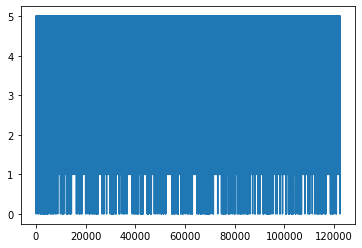

In [10]:
plot_requests_in_system(states)

In [11]:
def aver_times_in_states_each_step(states):
    requests_in_system_nums_unique = np.unique([state.requests_in_system_num for state in states])
    times = {num: 0 for num in requests_in_system_nums_unique}
    all_time = 0
    steps = []
    
    for i in range(len(states) - 1):
        current_time = states[i + 1].time - states[i].time
        all_time += current_time
        
        times[states[i].requests_in_system_num] += current_time
        steps.append({state: time / all_time for state, time in times.items()})
        
    return steps

In [12]:
aver_times_steps = aver_times_in_states_each_step(states)
final_aver_times_step = aver_times_steps[-1]

final_aver_times_step

{0: 0.005671776605451518,
 1: 0.03465323840764611,
 2: 0.10153640163743907,
 3: 0.20204505738644296,
 4: 0.29797298408111683,
 5: 0.35812054188190356}

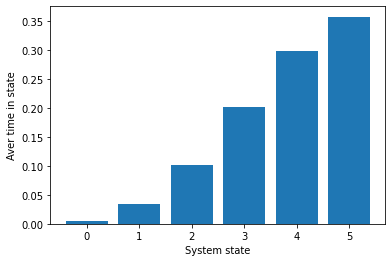

In [13]:
plt.bar(final_aver_times_step.keys(), final_aver_times_step.values());
plt.xlabel('System state')
plt.ylabel('Aver time in state');

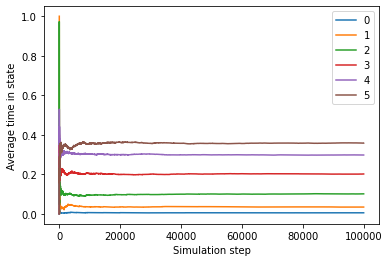

In [14]:
all_requests_in_system_nums = {num: [] for num in final_aver_times_step.keys()}

for aver_times_step in aver_times_steps:
    for requests_in_system_num, aver_time in aver_times_step.items():
        all_requests_in_system_nums[requests_in_system_num].append(aver_time)
        
for all_times in all_requests_in_system_nums.values():
    plt.plot(range(len(all_times)), all_times)

plt.legend(all_requests_in_system_nums.keys())
plt.xlabel('Simulation step')
plt.ylabel('Average time in state');

In [15]:
def requests_in_system_aver_num(states):
    aver_num, all_time = 0, 0
    
    for i in range(len(states) - 1):
        current_time = states[i + 1].time - states[i].time
        all_time += current_time
        aver_num += states[i].requests_in_system_num * current_time
        
    return aver_num / all_time

In [16]:
requests_in_system_aver_num(states)

3.8263558595758465

In [17]:
def loss_probs_with_channels(simulator, channels_num_range):
    loss_probs = []
    
    for channels_num in channels_num_range:
        simulator.max_requests_in_system_num = channels_num
        states = simulator.simulate()
        final_aver_times_step = aver_times_in_states_each_step(states)[-1]
        loss_probs.append(final_aver_times_step[max(final_aver_times_step.keys())])
        
    return loss_probs

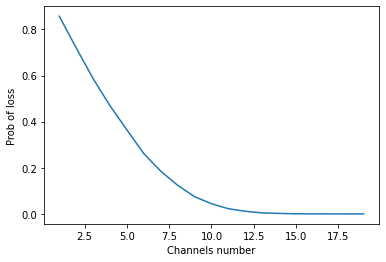

In [18]:
channels_num_range = range(1, 20)
loss_probs = loss_probs_with_channels(simulator, channels_num_range)

plt.plot(channels_num_range, loss_probs)
plt.xlabel('Channels number')
plt.ylabel('Prob of loss');